# Lab 3: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 17, 2018. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #library to visualize data
import sklearn.cluster as cluster # all clustering techniques but hdbscan
import scipy.spatial.distance as dist
import scipy as sc
import scipy.sparse.csgraph as sg
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

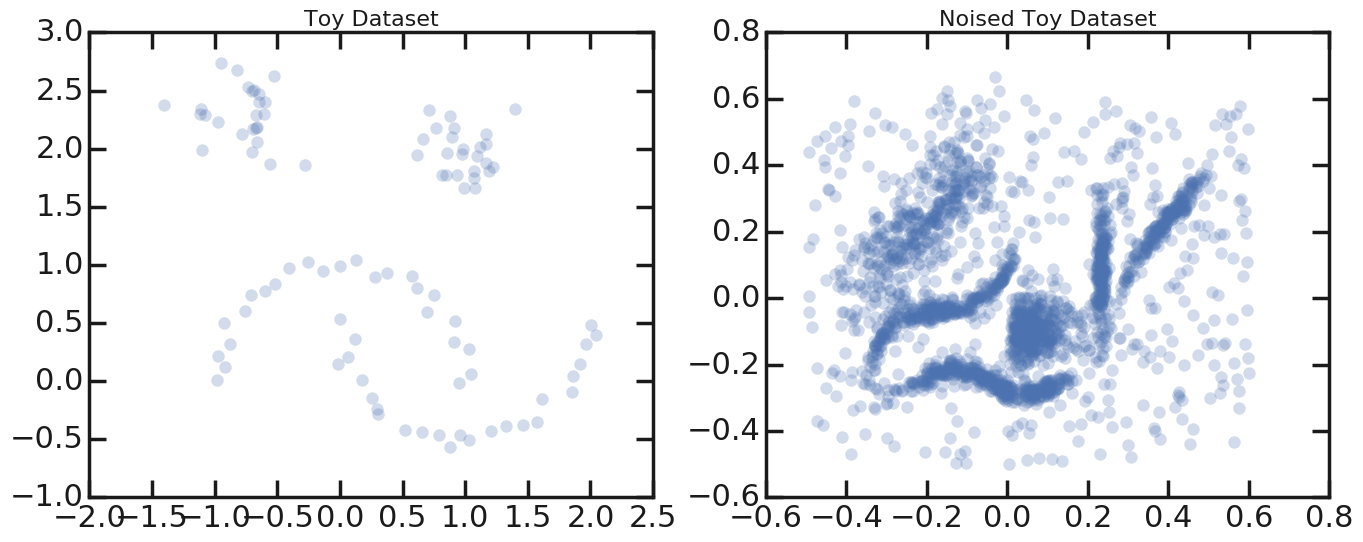

In [121]:
import sklearn.datasets as data #The sklearn.datasets package embeds some small toy datasets
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs]) #union of the data

test_data_1 = np.load('clusterable_data.npy')

#A scatter plot of y vs x with varying marker size and/or color.

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

# Comments 1:
On the left-side, figure Toy Dataset, we guess, obviously, the number of clusters is 4.
On the right-side, figure Noised Toy Dataset, we guess (!!) the number of class is 6

There are a lot of clustering algorithms to choose from `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

(2309L,)
61.4254931201
[ 0.02660264]


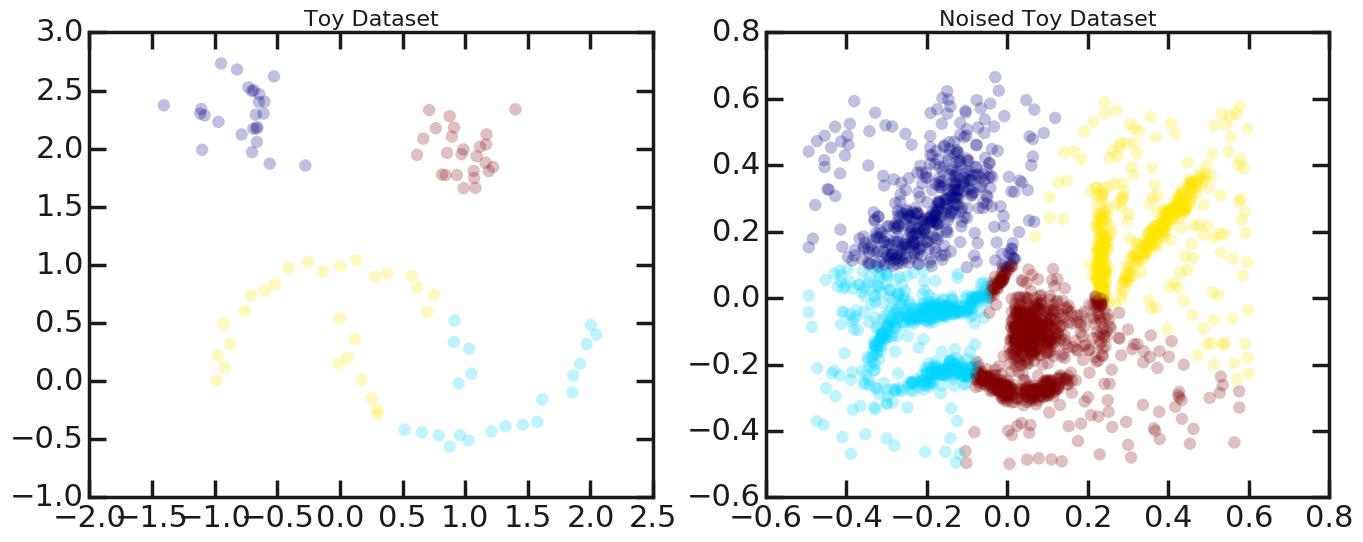

In [122]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

tmp = kmeans_1.inertia_

tmp = tmp/test_data_1.T[0].shape

print(test_data_1.T[0].shape)

print(kmeans_1.inertia_)

print(tmp)

plt.show();

# Comments 2:
On the left-side, figure Toy Dataset, we've noticed that k-means well distinguish convex clusters that does not overlap (like the set described by the two upper - clusters). Conversely, since k-means seek straight line as boundaries (like voronoi space), it is not able to catch non-convex shapes (like the set described by the two bottom - clusters).

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [123]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precompute compute the distance matrix
        # using from scipy.spatial import distance 
        
        # HINT:
        # You can use a minimum spanning tree and add merge in increasing order
        # or modifying the distance matrix 
        # (add row/column for new clusters and remove/put zero in old row/colums)
        
        # keep track of merges in linkage_matrix_ and labels in hierarchy_
        
        # update labels_ from the hierarchy level selected by n_clusters_ 
        
        #Compute the distances within each row
        n_coor = X.shape[0]
        #print(n_coor)
        row,col = np.triu_indices(n_coor,1)
        #Fill our matrix, the vertex is sorted
        s_l = np.sort(dist.pdist(X, 'euclidean'))
        #Distance matrix
        dist_matrix = np.zeros((n_coor, n_coor))
        dist_matrix[row,col] = dist.pdist(X, 'euclidean')  
        #Label initialization cluster 1 = 0, cluster 2 = 1, cluster = 2, cluster n = n-1
        self.labels_ = np.array(range(n_coor))
        #Initilization of hierarchy
        self.hierarchy_ = []
        #Number of iteration needed
        n_it = n_coor - self.n_clusters_
        #linkage_matrix_: (n-1, 4) np.array in the same format as linkage
        self.linkage_matrix_ = np.zeros((n_it,4))
        #Adding the first values
        it = 0
        i_d = 0
        #print("Distanze:"+" "+str(s_l))
        #print("Num distanze: "+" "+str(len(s_l)))
        while it < n_it:
            #Extract the min value
            min_dist = s_l[i_d]
            #Extract all the corresponding indexes
            argm = np.where(dist_matrix == min_dist)
            #print("Argm[0]:"+str(argm[0]))
            #print("Argm[1]:"+str(argm[1]))
            #Extract how many elements has the same distance
            n_el_eq = len(argm[0])
            #print("Num elementi con distanza uguale: "+" "+str(n_el_eq))
            #We have to consume all the couples...
            for k in range(n_el_eq):
                argm_0 = argm[0][k]
                argm_1 = argm[1][k]
                #Get the corresponding labels
                l_0 = self.labels_[argm_0]
                l_1 = self.labels_[argm_1]
                if(l_0 != l_1):
                    #Create a new label l_new
                    l_new =  n_coor + it
                    #Update labels
                    for j in range(n_coor):
                        if(self.labels_[j] == l_0 or self.labels_[j] == l_1):
                            self.labels_[j] = l_new
                    #print(self.labels_)
                    #Update the hierarchy
                    self.hierarchy_.append(self.labels_)
                    #And counting
                    n = 0
                    for j in list(range(n_coor)):
                        if(self.labels_[j] == l_new):
                            n += 1
                    #linkage processing
                    #Just ordering the values
                    if(l_0 > l_1):
                        o_l_0 = l_1
                        o_l_1 = l_0
                    else:
                        o_l_0 = l_0
                        o_l_1 = l_1
                        
                    self.linkage_matrix_[it,0] =  o_l_0
                    self.linkage_matrix_[it,1] =  o_l_1
                    self.linkage_matrix_[it,2] =  min_dist
                    self.linkage_matrix_[it,3] =  n
                    it += 1
                #print("k: "+" "+str(k))
                #print("i_d: "+" "+str(i_d))
                i_d += 1
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        sc.cluster.hierarchy.dendrogram(self.linkage_matrix_)

Apply the method to our toy datasets

True


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b'],
 'dcoord': [[0.0, 0.13436590572075002, 0.13436590572075002, 0.0],
  [0.0, 0.079052069443453193, 0.079052069443453193, 0.0],
  [0.0, 0.1032711340086913, 0.1032711340086913, 0.079052069443453193],
  [0.0, 0.029494641420216974, 0.029494641420216974, 0.0],
  [0.0, 0.090132806719867981, 0.0901328

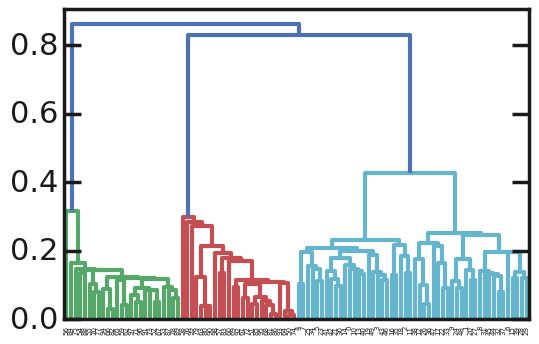

In [137]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram, linkage

m1 = my_SingleLinkageAglomerativeClustering("euclidean",1)
m1.fit(test_data_0)
Z = linkage(test_data_0)

#"Comparig the dendograms"
print(m1.linkage_matrix_ == Z).all()
  
#And we see with our eyes... 
dendrogram(m1.linkage_matrix_) 

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b'],
 'dcoord': [[0.0, 0.13436590572075002, 0.13436590572075002, 0.0],
  [0.0, 0.079052069443453193, 0.079052069443453193, 0.0],
  [0.0, 0.1032711340086913, 0.1032711340086913, 0.079052069443453193],
  [0.0, 0.029494641420216974, 0.029494641420216974, 0.0],
  [0.0, 0.090132806719867981, 0.0901328

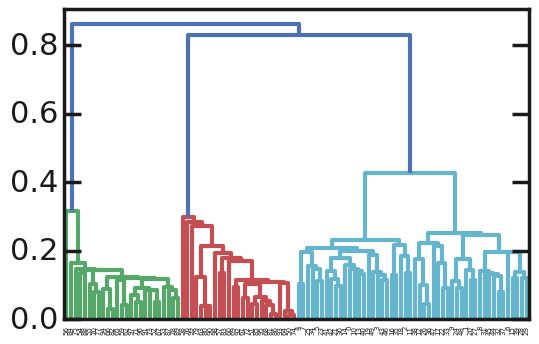

In [138]:
#Here's the automatic version
dendrogram(Z)

Try the different linkage methods implemented in `sklearn`  and comment

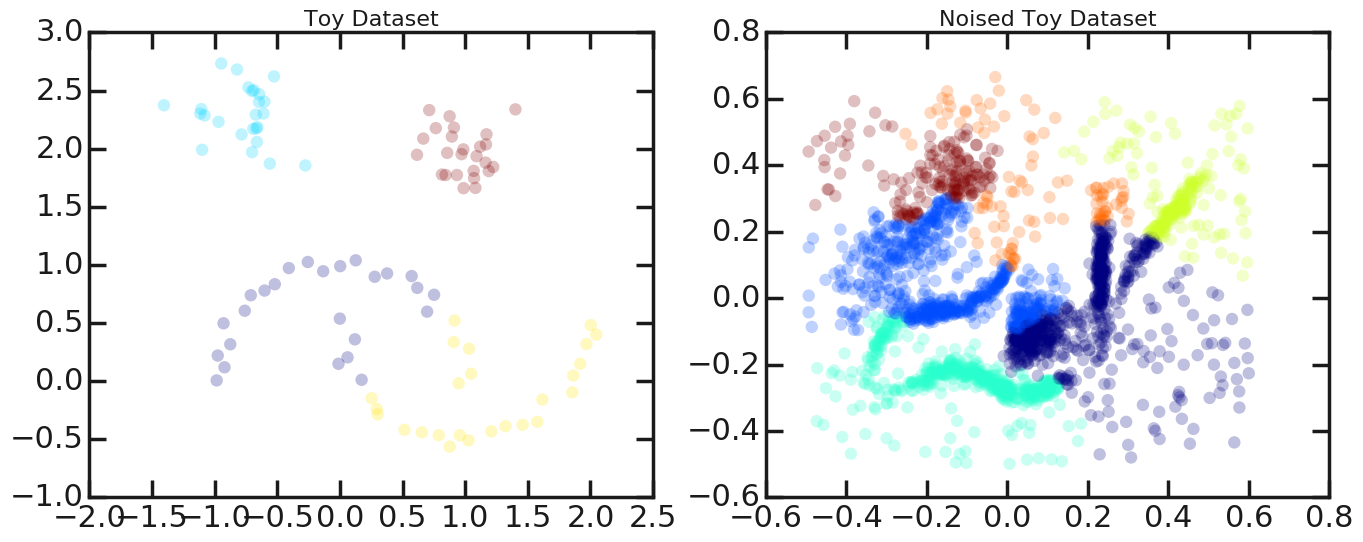

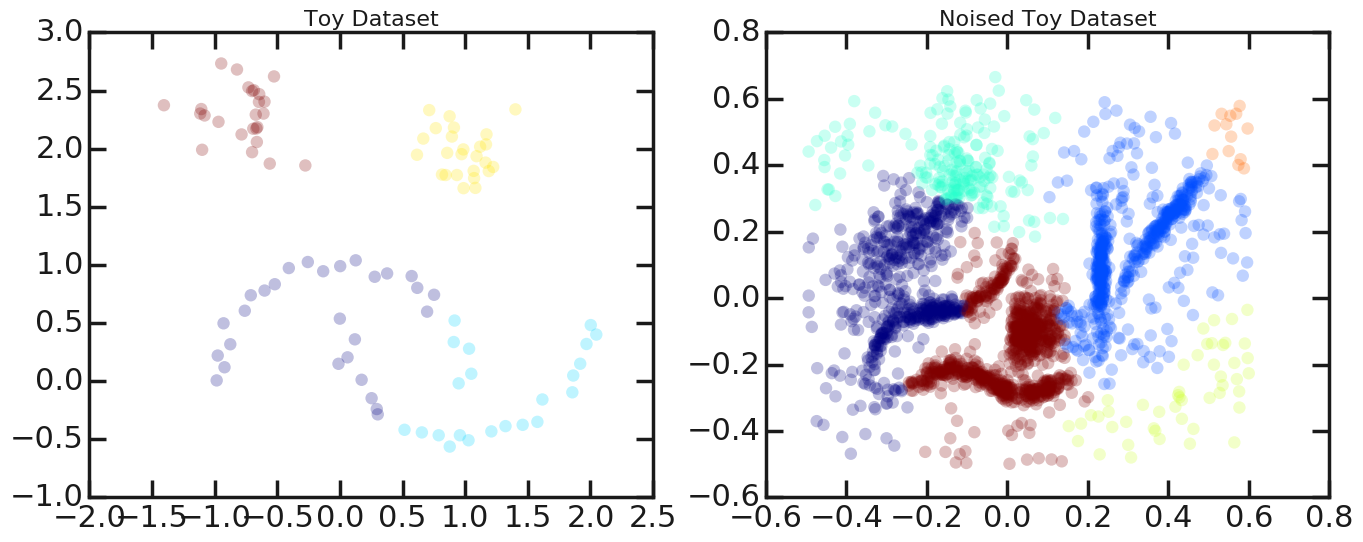

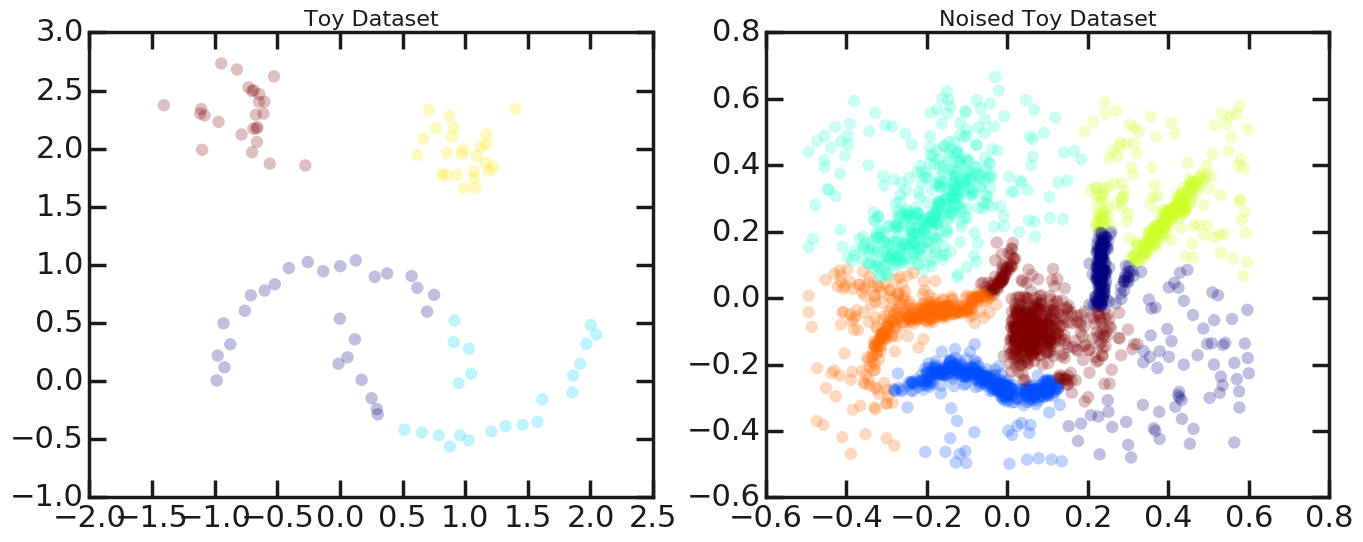

In [125]:
from sklearn.cluster import AgglomerativeClustering

# compute the agglomerative cluster for "linkage complete"
cluster_complete_1 = AgglomerativeClustering(n_clusters = 4, linkage='complete').fit(test_data_0)
cluster_complete_2 = AgglomerativeClustering(n_clusters = 6, linkage='complete').fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_complete_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=cluster_complete_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

# compute the agglomerative cluster for "linkage average"
cluster_average_1 = AgglomerativeClustering(n_clusters = 4, linkage='average').fit(test_data_0)
cluster_average_2 = AgglomerativeClustering(n_clusters = 6, linkage='average').fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_average_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=cluster_average_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

# compute the agglomerative cluster for "linkage ward"
cluster_ward_1 = AgglomerativeClustering(n_clusters = 4, linkage='ward').fit(test_data_0)
cluster_ward_2 = AgglomerativeClustering(n_clusters = 6, linkage='ward').fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_ward_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=cluster_ward_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

# Comments 3:
For the sake of clarity, we decided to put n_cluster = number of real cluster 
(4 for the first dataset, 6 for the second one), in all the simulations. 

The three leftside plot exhibit the same behaviour with all the tested Inter-Cluster distances: 
the two upper cluster are well identified while the two bottom cluster aren't. 

Results are worse on the rigth plots: no cluster are perfectly identified. At least, we can see the
differences induced by the choice of the inter-cluster distance. We see here the limitations of 
a inter-cluster distance based approach.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

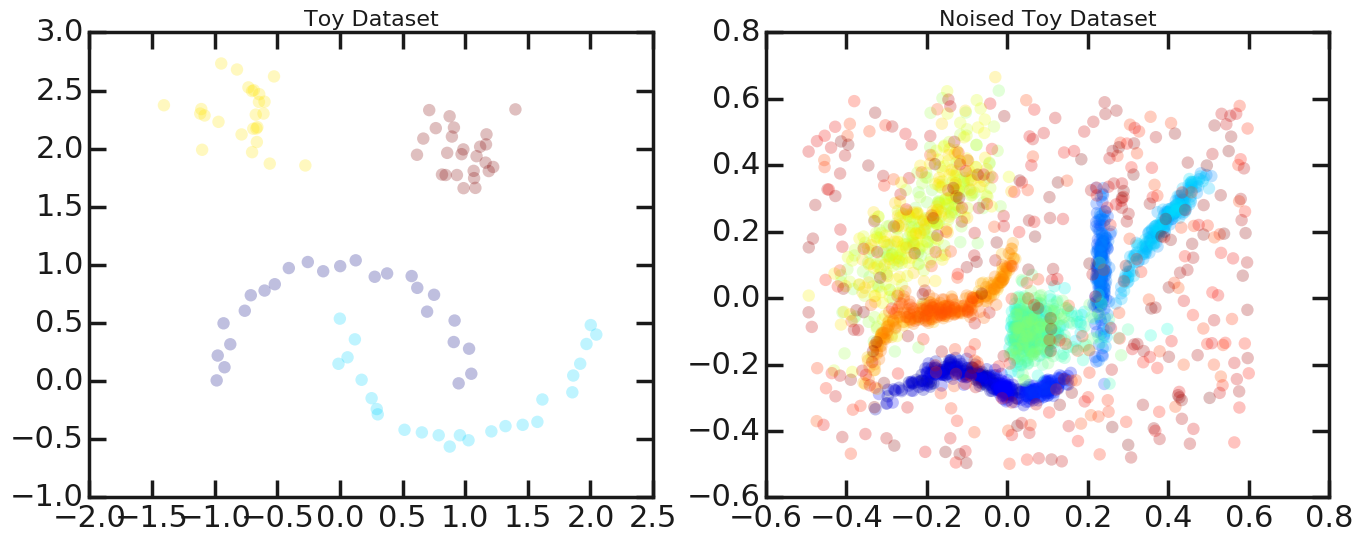

In [126]:
from sklearn.cluster import DBSCAN

cluster_dbscan_1 = DBSCAN(eps = 0.4, min_samples = 5).fit(test_data_0)
cluster_dbscan_2 = DBSCAN(eps = 0.00002, min_samples = 1).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_dbscan_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=cluster_dbscan_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

# Comment 4:

Severals simulations have been carried out using differentes couple (eps, min_samples) of tuning parameters and the one retained gives satisfactory perfomances: 

1) On the left-side, figure Toy Dataset, the 4 real clusters were identified.

2) On the left-side, figure Noised Toy Dataset, the 6 real clusters were quite well identified (thanks to the high density of points in each cluster). However, noisy points are not perfectly classified as such.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

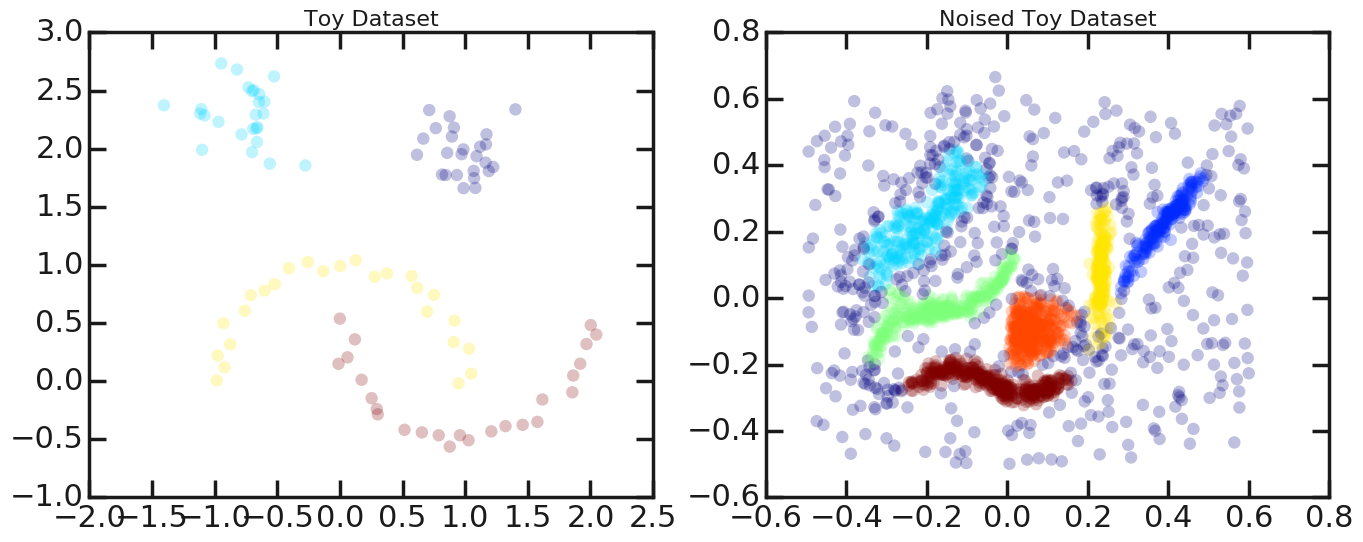

In [127]:
import hdbscan

cluster_hdbscan_1 = hdbscan.HDBSCAN(min_samples = 2).fit(test_data_0)
cluster_hdbscan_2 = hdbscan.HDBSCAN(min_samples = 15).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_hdbscan_1.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=cluster_hdbscan_2.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

# Comment 5:

On the left-side, figure Toy Dataset, as for DBSCAN, cluster are perfect identified.

On the right-side, figure Noised Toy Dataset, the big difference with DBSCAN is that noise points are classified as such: this is due to the new distance (mutual reachability distance) that transform the space and spread apart points with low density. 

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


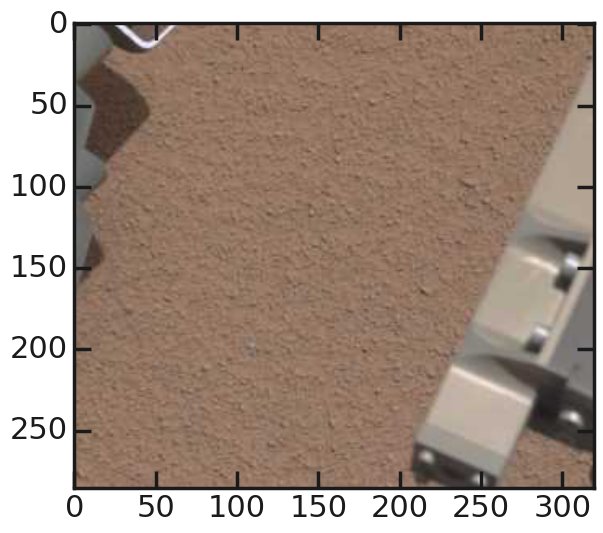

In [17]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')
fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [83]:
n_x_axes = Im_1.size[0]
n_y_axes = Im_1.size[1]
def img_pro(Im_1,n_x_axes,n_y_axes):
    pix = Im_1.load()
    n_elem = n_x_axes * n_y_axes

    I = np.zeros((n_y_axes,n_x_axes))
    S = np.zeros((n_y_axes,n_x_axes))

    for i_x in range(n_y_axes):
        for i_y in range(n_x_axes):
            I[i_x,i_y] = sum(pix[i_y,i_x])/3
            S[i_x,i_y] = 1 - I[i_x,i_y]*min(pix[i_y,i_x])
    #Just reshaping
    return np.hstack([I.reshape((n_elem, 1)), S.reshape((n_elem, 1))])
IS = img_pro(Im_1,n_x_axes,n_y_axes)

- Apply the seen algorithms to segment the image, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

[ -1 394  -1 ...,  -1  -1  -1]


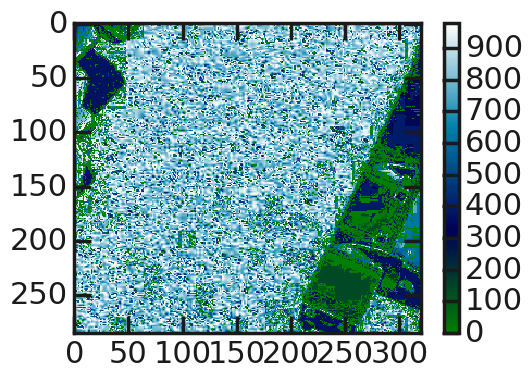

In [131]:
def print_plot(matrix):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.ocean)
    plt.colorbar()
    plt.show()   
    return

cluster_img = hdbscan.HDBSCAN(min_samples = 1000).fit(IS)

m_tbp = cluster_img.labels_.reshape(n_y_axes,n_x_axes)
print_plot(m_tbp)

# Comment 6:

We can identify a green square on mars surface that has been assigned to the same cluster as the robot.

If we inspect in the real photo we see an object that looks like a screw. This is a good result, since the image segmantation well represents the original image: even shadows are well determined.

Notice that other faded green squares are represented: actually there's a correspondence on the real image with the grey "spot".

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

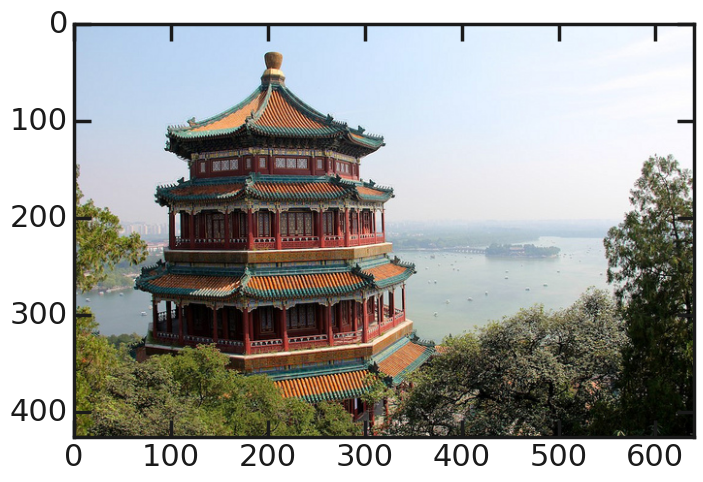

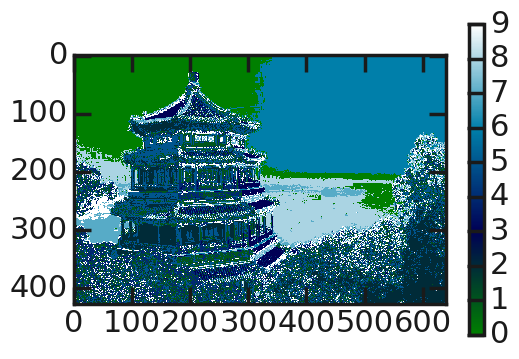

In [139]:
from sklearn.datasets import load_sample_image
#Very rich version
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);
n0 = china.shape[0]
n1 = china.shape[1]

data = china.reshape(n0*n1,3)
reduced_china = KMeans(n_clusters=10, max_iter=200).fit(data)
matr = reduced_china.labels_.reshape(n0,n1)
print_plot(matr)

# Comment 7:

The goal of color compression is achieved since the ten-colored version of the image well approximate the original one.